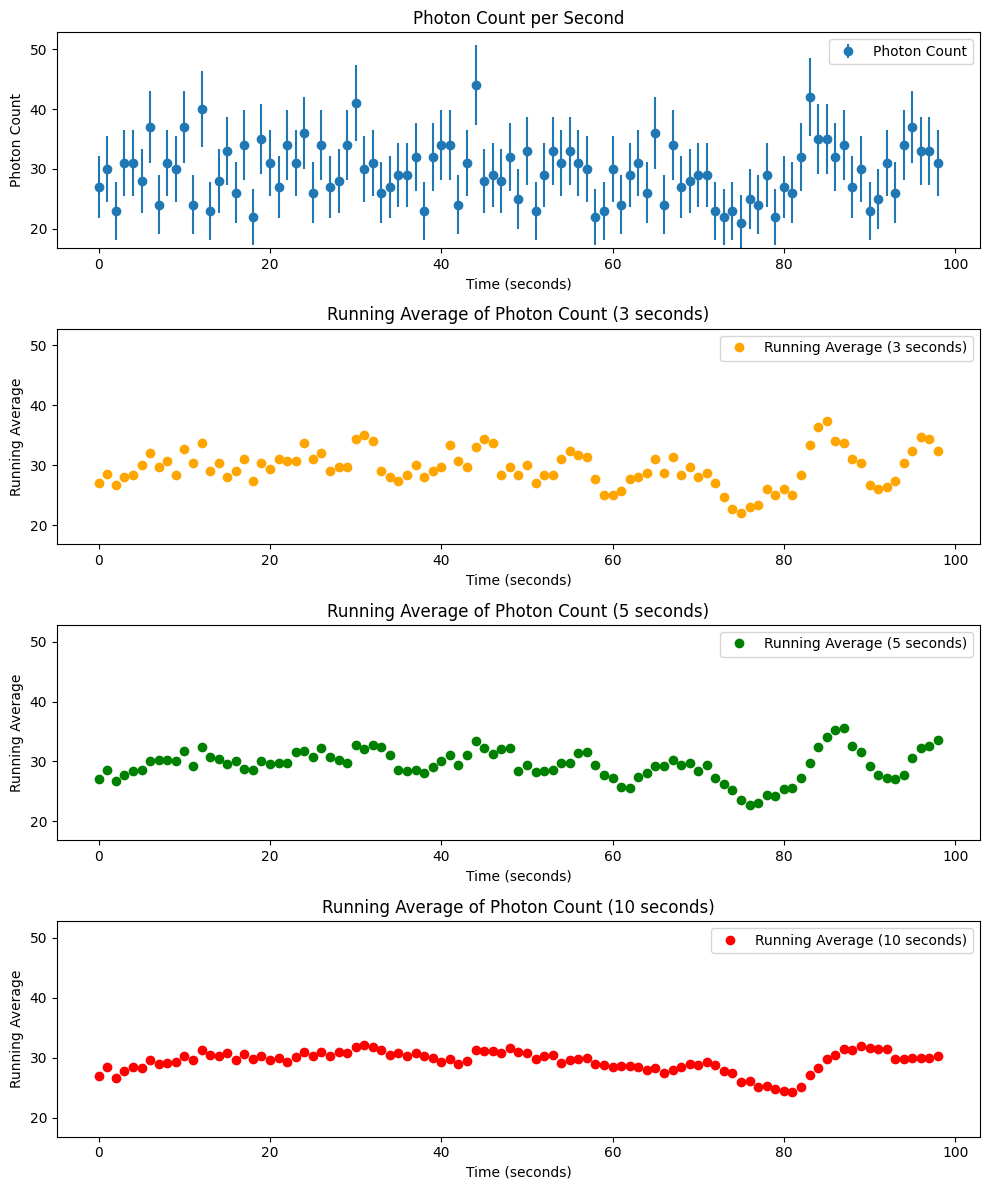

In [3]:
#　T. Takahashi (2024/June/10)

import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# Define the power law function.
def power_law(index, min_energy, max_energy):
    random_value = np.random.uniform(0, 1)
    energy = ((max_energy**(index + 1) - min_energy**(index + 1)) * random_value + min_energy**(index + 1))**(1/(index + 1))
    return energy

# Define the Get_Energy function.
def Get_Energy():
    index = -2.0  # Index of the spectrum.
    min_energy = 1.0  # Minimum energy.
    max_energy = 1000.0  # Maximum energy.
    energy = power_law(index, min_energy, max_energy)
    return energy

# Function to return the next photon's occurrence time and energy.
def get_photon_next(rate):
    time_to_next_event = np.random.exponential(1 / rate)
    photon_energy = Get_Energy()
    return time_to_next_event, photon_energy

# Define the FixedLengthLIFOQueue class for photon counts
class FixedLengthLIFOQueue:
    def __init__(self, length):
        self.queue = deque(maxlen=length)  # Initialize the deque with a fixed length
        self.running_sum = 0  # Initialize the running sum

    def push(self, item):
        if len(self.queue) == self.queue.maxlen:
            self.running_sum -= self.queue[-1]  # Subtract the rightmost item if the queue is full
        self.queue.appendleft(item)  # Append item to the left end of the queue
        self.running_sum += item  # Add the new item to the running sum

    def pop(self):
        if self.queue:
            item = self.queue.pop()  # Pop the last item from the right end of the queue
            self.running_sum -= item  # Subtract the popped item from the running sum
            return item
        else:
            return None  # Return None if the queue is empty

    def get_last(self):
        if self.queue:
            return self.queue[-1]  # Return the last item in the queue without removing it
        else:
            return None  # Return None if the queue is empty

    def get_first(self):
        if self.queue:
            return self.queue[0]  # Return the first item in the queue without removing it
        else:
            return None  # Return None if the queue is empty

    def size(self):
        return len(self.queue)  # Return the length of the queue

    def get_item(self, index):
        if 0 <= index < len(self.queue):
            return self.queue[index]  # Return the item at the specified index
        else:
            return None  # Return None if the index is out of range

    def get_running_average(self):
        if self.queue:
            return self.running_sum / len(self.queue)  # Return the running average
        else:
            return 0  # Return 0 if the queue is empty

# Seed for reproducibility
np.random.seed(113)

# Simulation parameters
duration = 100  # Duration of the simulation in seconds
rate = 30  # Rate of photon arrival per second
size_list = 600  # Length of the photon list queue

# Initialize the FixedLengthLIFOQueue for photon counts
photon_list_queue = deque(maxlen=size_list)

# Start the simulation
current_time = 0
accumulated_time = 0
photon_count_in_last_second = 0

# Store data for plotting
photon_count_data = []
running_average_3s = []
running_average_5s = []
running_average_10s = []

# Initialize the FixedLengthLIFOQueue for running averages
photon_count_queue_3s = FixedLengthLIFOQueue(3)
photon_count_queue_5s = FixedLengthLIFOQueue(5)
photon_count_queue_10s = FixedLengthLIFOQueue(10)

while current_time < duration:
    time_to_next_event, photon_energy = get_photon_next(rate)
    current_time += time_to_next_event
    accumulated_time += time_to_next_event

    if current_time < duration:
        photon_list_queue.appendleft((current_time, photon_energy))
        photon_count_in_last_second += 1
        
        if accumulated_time >= 1:
            # Push the photon count for the last second into the photon count queues
            photon_count_queue_3s.push(photon_count_in_last_second)
            photon_count_queue_5s.push(photon_count_in_last_second)
            photon_count_queue_10s.push(photon_count_in_last_second)
            
            # Calculate the running averages
            running_average_3s.append(photon_count_queue_3s.get_running_average())
            running_average_5s.append(photon_count_queue_5s.get_running_average())
            running_average_10s.append(photon_count_queue_10s.get_running_average())

            # Store data for plotting
            photon_count_data.append(photon_count_in_last_second)

            # Reset for the next second
            photon_count_in_last_second = 0
            accumulated_time -= 1

# Determine the common y-axis range
y_min = min(photon_count_data)
y_max = max(photon_count_data)
y_range_min = y_min * 0.8
y_range_max = y_max * 1.2

# Calculate errors for photon count data
photon_count_errors = [np.sqrt(count) for count in photon_count_data]

# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

# Plot photon counts with error bars
ax1.errorbar(range(len(photon_count_data)), photon_count_data, yerr=photon_count_errors, fmt='o', label='Photon Count')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Photon Count')
ax1.set_title('Photon Count per Second')
ax1.set_ylim(y_range_min, y_range_max)  # Set the same y-axis range for all plots
ax1.legend()

# Plot running average for 3 seconds
ax2.plot(running_average_3s, 'o', label='Running Average (3 seconds)', color='orange')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Running Average')
ax2.set_title('Running Average of Photon Count (3 seconds)')
ax2.set_ylim(y_range_min, y_range_max)  # Set the same y-axis range for all plots
ax2.legend()

# Plot running average for 5 seconds
ax3.plot(running_average_5s, 'o', label='Running Average (5 seconds)', color='green')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Running Average')
ax3.set_title('Running Average of Photon Count (5 seconds)')
ax3.set_ylim(y_range_min, y_range_max)  # Set the same y-axis range for all plots
ax3.legend()

# Plot running average for 10 seconds
ax4.plot(running_average_10s, 'o', label='Running Average (10 seconds)', color='red')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Running Average')
ax4.set_title('Running Average of Photon Count (10 seconds)')
ax4.set_ylim(y_range_min, y_range_max)  # Set the same y-axis range for all plots
ax4.legend()

plt.tight_layout()
plt.show()
